In [1]:
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import average_precision_score


## Data Manipulation

In [2]:
raw_df = pd.read_pickle('../data/training_df.pkl')
ddict = pd.read_pickle('../data_dict/data_dictionary.pkl')

In [3]:
raw_df.head()

,PID,numerics,codes,to_event,target
0,2570828,"[[], [], [], [], [], [], []]","[[129, 4, 133, 69, 136, 458, 459, 492, 45, 524...","[0, 180, 244, 300, 323, 685, 716]",0
1,2570828,"[[], [], [], [], [], [], []]","[[129, 4, 133, 69, 136, 458, 459, 492, 45, 524...","[0, 180, 244, 300, 323, 685, 716]",0
2,2650036,"[[], [], [], [], []]","[[129, 4, 133, 70, 458, 524, 460, 78, 46, 528,...","[0, 79, 89, 96, 99]",1
3,2650036,"[[], [], [], [], [], [], []]","[[129, 4, 133, 70, 458, 524, 460, 78, 46, 528,...","[0, 79, 89, 96, 99, 119, 135]",1
4,2650036,"[[], [], [], [], [], [], [], [], [], []]","[[129, 4, 133, 70, 458, 524, 460, 78, 46, 528,...","[0, 79, 89, 96, 99, 119, 135, 149, 156, 161]",1


In [4]:
raw_df.target.value_counts()

1    411
0    182
Name: target, dtype: int64

In [5]:
def collapse_features(feature_list):
    feat_dict = {}
    for l in feature_list:
        for f in l:
            feat_dict[f] = feat_dict.get(f, 0) + 1
    return feat_dict

In [6]:
raw_df['code_counts'] = raw_df.codes.apply(collapse_features)
raw_df['last_day'] = raw_df.to_event.apply(max)
raw_df['n_events'] = raw_df.to_event.apply(len)

code_data = raw_df.code_counts.apply(pd.Series).fillna(0)

In [7]:
df = pd.concat([raw_df[['PID', 'target', 'last_day', 'n_events']], code_data], axis=1)
df.head()

,PID,target,last_day,n_events,0,1,2,3,4,5,...,628,629,630,632,633,634,635,636,637,638
0,2570828,0,716,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2570828,0,716,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2650036,1,99,5,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
3,2650036,1,135,7,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0
4,2650036,1,161,10,2.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,5.0


In [8]:
df.target.value_counts()

1    411
0    182
Name: target, dtype: int64

In [9]:
df.to_pickle('training_df_wide.pkl')

## Aggregated data

By PID:

- Sum all the features
- Take the event day
- Target is 1 if there is ever a relapse

In [10]:
df_agg = df.copy()

In [11]:
df_agg.shape

(593, 236)

In [12]:
print('Number of unique patients')
df_agg.PID.nunique()

Number of unique patients


235

In [13]:
print('Count of relapse vs. no-relapse')
df_agg.target.value_counts()

Count of relapse vs. no-relapse


1    411
0    182
Name: target, dtype: int64

## Boosting

In [14]:
# import packages
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split

rand_seed = 123456

In [15]:
df_agg.head()

,PID,target,last_day,n_events,0,1,2,3,4,5,...,628,629,630,632,633,634,635,636,637,638
0,2570828,0,716,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2570828,0,716,7,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2650036,1,99,5,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
3,2650036,1,135,7,2.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0
4,2650036,1,161,10,2.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,5.0


## Gradient Boosting Aggregated Dataset

In [16]:
X = df_agg.iloc[:, 3:] # pd.concat([df_agg.event_day, df_agg.iloc[:, 3:]], axis=1)
y = df_agg.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = rand_seed)

In [17]:
y_train.value_counts()

1    303
0    141
Name: target, dtype: int64

In [18]:
y_test.value_counts()

1    108
0     41
Name: target, dtype: int64

In [19]:
gb = GradientBoostingClassifier(learning_rate=0.06, n_estimators=200, random_state=rand_seed)
#gb = XGBClassifier(learning_rate=0.2, n_estimators=500)
gb.fit(X_train, y_train)
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [20]:
print('F1 score for train set: ', f1_score(y_train, y_train_pred))
print('F1 score for test set: ', f1_score(y_test, y_test_pred))

F1 score for train set:  0.9275808936825887
F1 score for test set:  0.8154506437768241


In [21]:
from sklearn.metrics import accuracy_score

print('ACC score for train set: ', accuracy_score(y_train, y_train_pred))
print('ACC score for test set: ', accuracy_score(y_test, y_test_pred))

ACC score for train set:  0.8941441441441441
ACC score for test set:  0.7114093959731543


In [23]:
print('Confusion matrix for train set: ')
confusion_matrix(y_train, y_train_pred)

Confusion matrix for train set: 


array([[ 96,  45],
       [  2, 301]])

In [24]:
print('Confusion matrix for test set: ')
confusion_matrix(y_test, y_test_pred)

Confusion matrix for test set: 


array([[11, 30],
       [13, 95]])

In [25]:
average_precision = average_precision_score(y_test, y_test_pred)

print('Average precision-recall score (PR-AUC): {0:0.2f}'.format(
      average_precision))

Average precision-recall score (PR-AUC): 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: PR-AUC=0.76')

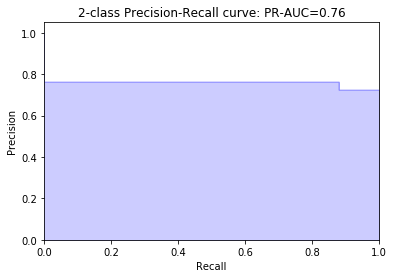

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: PR-AUC={0:0.2f}'.format(
          average_precision))


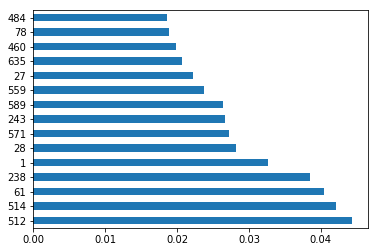

In [27]:
feature_importance = pd.Series(gb.feature_importances_, index=X_train.columns)
feature_importance.nlargest(15).plot(kind='barh')

In [28]:
feature_list = list(feature_importance.nlargest(15).index)
[ddict.get(x) for x in feature_list if x != 'n_events']

['txage_4',
 'w_isp_stop_2',
 'hct1_mrd___4',
 'proph_dli_10',
 'DLI',
 'e_response_2',
 'w_treatment_cytokine_2',
 'proph_dli_6',
 'w_treatment_induction_7',
 'w_sub_intrathecal___4',
 'e_response_1',
 None,
 'relage_1',
 'hct2_conditioning___12',
 'relapse_mutations___8']

## Upsampling: XGBoosting with upsampled aggregated dataset

In [141]:
df_agg.target.value_counts()

1    411
0    182
Name: target, dtype: int64

In [142]:
import numpy as np
def split_by_pid(df, split_percent = 0.1, seed = 123):
    """
    partition holdout/test set at pid level
    :param df: input data
    :param holdout_percent: % of data hold out for testing
    :return: two sets: train and test
    """
    np.random.seed(seed)

    # get unique patient list (sorted acs)
    id_list = np.sort((df.PID.unique()))
    perm = np.random.permutation(id_list)
    n_id = len(id_list)
    sep_index = int(n_id*split_percent)
    
    test = df.loc[df.PID.isin(perm[:sep_index])]
    train = df.loc[df.PID.isin(perm[sep_index:])]

    return train, test

In [143]:
main, holdout = split_by_pid(df_agg, split_percent=0.2, seed = rand_seed)

In [144]:
holdout.target.value_counts()

1    90
0    44
Name: target, dtype: int64

In [145]:
main.target.value_counts()

1    321
0    138
Name: target, dtype: int64

In [146]:
from sklearn.utils import resample
relapse = main[main.target==1]
no_relapse = main[main.target==0]

no_relapse_upsampled = resample(no_relapse, replace=True, n_samples=len(relapse))
upsampled = pd.concat([no_relapse_upsampled, relapse])
upsampled.target.value_counts()

1    321
0    321
Name: target, dtype: int64

In [147]:
X = upsampled.iloc[:, 3:] # pd.concat([upsampled.event_day, upsampled.iloc[:, 3:]], axis = 1)
y = upsampled.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = rand_seed)

X_hold = holdout.iloc[:, 3:]
y_hold = holdout.target

In [148]:
X.head()

,n_events,0,1,2,3,4,5,6,7,8,...,628,629,630,632,633,634,635,636,637,638
0,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,6,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0
126,12,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0
433,6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
0,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
#gb = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, random_state=rand_seed)
from xgboost import XGBClassifier
gb = XGBClassifier(learning_rate=0.1, n_estimators=200, random_state=rand_seed)
gb.fit(X_train, y_train)

y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)
y_hold_pred = gb.predict(X_hold)

In [190]:
print('F1 score for train set: ', f1_score(y_train, y_train_pred))
print('F1 score for test set: ', f1_score(y_test, y_test_pred))
print('F1 score for holdout set: ', f1_score(y_hold, y_hold_pred))

F1 score for train set:  0.9735234215885947
F1 score for test set:  0.7972027972027972
F1 score for holdout set:  0.7738693467336683


In [191]:
print('Confusion matrix for train set: ')
confusion_matrix(y_train, y_train_pred)

Confusion matrix for train set: 


array([[229,   7],
       [  6, 239]])

In [192]:
print('Confusion matrix for test set: ')
confusion_matrix(y_test, y_test_pred)

Confusion matrix for test set: 


array([[75, 10],
       [19, 57]])

In [193]:
print('Confusion matrix for holdout set: ')
confusion_matrix(y_hold, y_hold_pred)

Confusion matrix for holdout set: 


array([[12, 32],
       [13, 77]])

In [194]:
average_precision = average_precision_score(y_test, y_test_pred)

print('Average precision-recall score (PR-AUC): {0:0.2f}'.format(
      average_precision))

Average precision-recall score (PR-AUC): 0.76


Text(0.5, 1.0, '2-class Precision-Recall curve: PR-AUC=0.76')

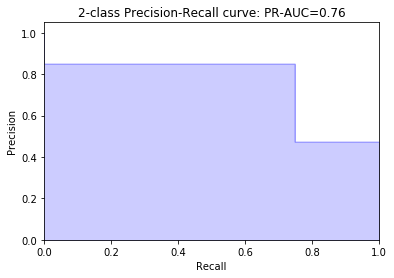

In [195]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: PR-AUC={0:0.2f}'.format(
          average_precision))


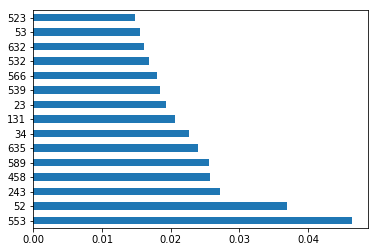

In [196]:
feature_importance = pd.Series(gb.feature_importances_, index=X_train.columns)
feature_importance.nlargest(15).plot(kind='barh')

In [197]:
feature_list = list(feature_importance.nlargest(15).index)
[ddict.get(x, 'n_events') for x in feature_list]

['w_sub_hct_donor_2',
 'hct1_dx_5',
 'proph_dli_6',
 'rel_proph___9',
 'w_treatment_induction_7',
 'n_events',
 'eln_final_index_relapse_6',
 'p_dli_paired_cytokine_2',
 'e_gvhd_1',
 'w_sub_agvh_organs___5',
 'w_treatment_consolidation_5',
 'w_sub_agvh_grade_1',
 'n_events',
 'hct1_dx_6',
 'w_relapse_2']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.856878 using {'learning_rate': 0.3, 'n_estimators': 400}
0.680917 (0.061414) with: {'learning_rate': 0.01, 'n_estimators': 25}
0.695758 (0.059973) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.703400 (0.058005) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.731600 (0.062157) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.743467 (0.060920) with: {'learning_rate': 0.01, 'n_estimators': 300}
0.751776 (0.063393) with: {'learning_rate': 0.01, 'n_estimators': 400}
0.758140 (0.064816) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.715939 (0.061535) with: {'learning_rate': 0.05, 'n_estimators': 25}
0.719114 (0.067510) with: {'learning_rate': 0.05, 'n_estimators': 50}
0.763682 (0.057622) with: {'learning_rate': 0.05, 'n_estimators': 100}
0.759902 (0.076569) with: {'learning_rate': 0.05, 'n_estimators': 200}
0.766091 (0.086603) with: {'learning_rate': 0.05, 'n_estimators': 300}
0.798261 (0.084111) with: {'learning_rate': 0.05, 'n_estimators': 400}
0.809525 (0.0811

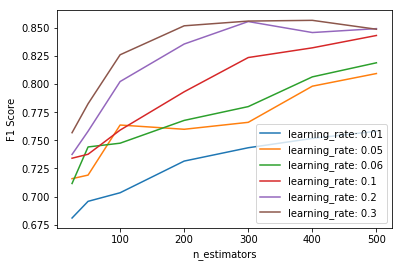

In [158]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import numpy
from matplotlib import pyplot

# grid search
model = XGBClassifier()
n_estimators = [25, 50, 100, 200, 300, 400, 500]
learning_rate = [0.01, 0.05, 0.06, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    pyplot.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('F1 Score')
pyplot.savefig('n_estimators_vs_learning_rate.png')

In [200]:
kfold = 5
from sklearn.model_selection import GroupKFold

cv = GroupKFold(n_splits=kfold)
cv.get_n_splits(X,y,groups=upsampled.PID)
cv_splits = cv.split(X, y, groups=upsampled.PID)

for train_idx, test_idx in cv_splits:
    # split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    gb = XGBClassifier(learning_rate=0.1, n_estimators=200, random_state=rand_seed)
    gb.fit(X_train, y_train)
    y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)

    print('F1 score for train set: ', f1_score(y_train, y_train_pred))
    print('F1 score for test set: ', f1_score(y_test, y_test_pred))
    print('F1 score for holdout set: ', f1_score(y_hold, y_hold_pred))
    
    print('ACC score for train set: ', accuracy_score(y_train, y_train_pred))
    print('ACC score for test set: ', accuracy_score(y_test, y_test_pred))
    print('ACC score for holdout set: ', accuracy_score(y_hold, y_hold_pred))
    
    print('Confusion matrix for train set: ')
    print(confusion_matrix(y_train, y_train_pred))

    print('Confusion matrix for test set: ')
    print(confusion_matrix(y_test, y_test_pred))

    print('Confusion matrix for holdout set: ')
    print(confusion_matrix(y_hold, y_hold_pred))


F1 score for train set:  0.9706457925636007
F1 score for test set:  0.5633802816901409
F1 score for holdout set:  0.7738693467336683
ACC score for train set:  0.9707602339181286
ACC score for test set:  0.5193798449612403
ACC score for holdout set:  0.664179104477612
Confusion matrix for train set: 
[[250   4]
 [ 11 248]]
Confusion matrix for test set: 
[[27 40]
 [22 40]]
Confusion matrix for holdout set: 
[[12 32]
 [13 77]]
F1 score for train set:  0.9543568464730291
F1 score for test set:  0.7195767195767194
F1 score for holdout set:  0.7738693467336683
ACC score for train set:  0.9571150097465887
ACC score for test set:  0.5891472868217055
ACC score for holdout set:  0.664179104477612
Confusion matrix for train set: 
[[261  10]
 [ 12 230]]
Confusion matrix for test set: 
[[ 8 42]
 [11 68]]
Confusion matrix for holdout set: 
[[12 32]
 [13 77]]
F1 score for train set:  0.9823182711198427
F1 score for test set:  0.6474820143884892
F1 score for holdout set:  0.7738693467336683
ACC score